# Final ELN model interpretation

## Outline

The **MLAging - all-cell** workflow consists of sections:

`00 preprocessing.R` Data preprocessing and preparation in Seurat.

`111 All-cell Model Tuning - Before Binarization` ML model tunning using *non-binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`112 All-cell Model Tuning - After Binarization` ML model tunning using *binarized* HVGs.

`121 All-cell Model 10x - Before Binarization` Run the best models for non-binarized* HVGs over 10 random seeds.

`122 All-cell Model 10x - After Binarization` Run the best models for *binarized* HVGs over 10 random seeds.
 
`123 All-cell Model 10x Swapped Train-Test` Run the best models for *binarized* HVGs over 10 random seeds. But switched the training and test sets to make sure that the sequencing throughput did not affect model performance.

`13 All-cell Model Result Viz` Result visulization.

`14 All-cell ELN Interpretation` Result interpretation -- **this notebook**:
1. [Evaluation of the best model-- ELN](#5.-eval)
    - [ELN coefficients - all](#6.-cm)
    - [ELN coefficients - top20](#7.-top)


2. [Perturbation](#8.-per)


3. [Correlation matrix](#9.-corr)

In [1]:
from src.packages import *

import pylab
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.misc import derivative

## 1. Thorough evaluation of the best model<a name="5.-eval"></a>
### a) ELN coefficients <a name="6.-cm"></a>

In [2]:
# Load final models
file = open('../results/results_bin_best/eln_model_test_models.save', 'rb')
final_models = pickle.load(file)
file.close()

# Load final data
file = open('../results/results_bin_best/l1_model_test_sets.save', 'rb')
final_data = pickle.load(file)
file.close()

# Get data from final_data
X = final_data[0][0]

y_tests, y_tests_pred, y_tests_prob, coefs_list = [], [], [], []

# Iterate through final_data and final_models using zip
for (X_test, y_test), clf in zip(final_data, final_models):
    y_tests.append(y_test)
    y_tests_pred.append(clf.predict(X_test))
    y_tests_prob.append(clf.predict_proba(X_test))
    coefs_list.append(clf.coef_)

In [3]:
coefs_array = np.array(coefs_list)
mean_coefs = np.mean(coefs_array, axis=0)
std_coefs = np.std(coefs_array, axis=0)

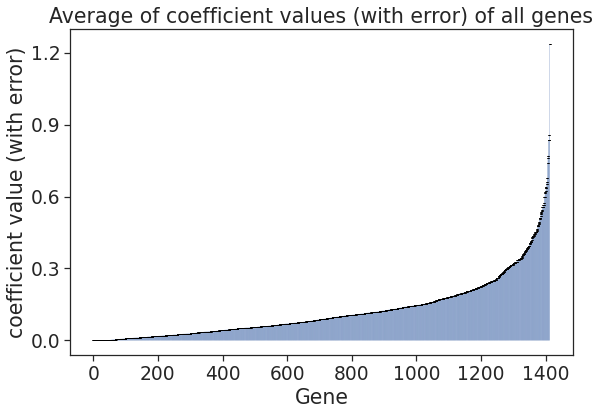

In [4]:
abs_coefs = np.absolute(mean_coefs)

plt.figure(figsize=(9,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), np.sort(abs_coefs[0]), yerr=std_coefs[0], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[4],
        linewidth=0.005,
        ecolor='black')

plt.ylabel("coefficient value (with error)")
plt.xlabel('Gene')
plt.title("Average of coefficient values (with error) of all genes")
plt.yticks([0, 0.3, 0.6, 0.9, 1.2])
# plt.savefig('../figures/3a_all_coefs_abs.PDF', bbox_inches='tight')
plt.show()

In [5]:
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs[0])]
results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

ranked_df = pd.DataFrame([(result[1], X.columns[result[0]]) for result in results], 
                         columns=["absolute_coef", "gene"])

ranked_df = ranked_df.reset_index(drop=True)

ranked_df = ranked_df.rename_axis("ranking", axis=1)
ranked_df.index = ranked_df.index + 1

ranked_df.head()
# ranked_df.to_csv('../results/ranked_genes.csv')
# read ranked_df
# pd.read_csv('../results/ranked_genes.csv', index_col=0)

ranking  absolute_coef     gene
1             1.235888  Slc5a4b
2             0.856934  Slc13a4
3             0.835560  Hormad1
4             0.835351    Adam2
5             0.770736      C4b

### b) ELN coefficients top 20 <a name="7.-top"></a>

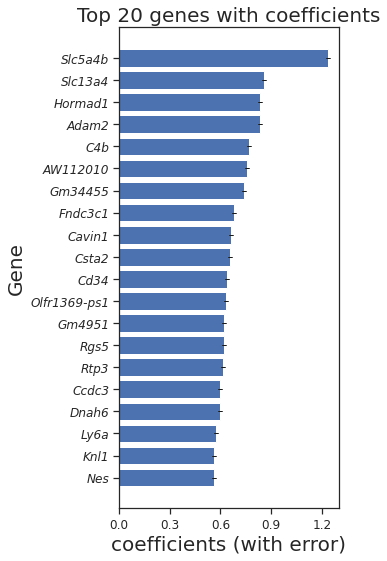

In [7]:
sns.color_palette()
plt.figure(figsize = (5,8))
sns.set(font_scale=1.1, style='ticks')
abs_coefs = np.absolute(mean_coefs)
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]

results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

nr_coefs = 20

top_coefs_result = [(result, X.columns[result[0]]) for result in results][:nr_coefs]
top_coefs_result.reverse()
top_coefs = [abs_coefs[t[0][0]] for t in top_coefs_result]
top_features = [t[1] for t in top_coefs_result]
std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

plt.barh(np.arange(nr_coefs), top_coefs, yerr=std_top_coefs, capsize=2)
plt.yticks(np.arange(nr_coefs),top_features, style='italic')
plt.xlabel("coefficients (with error)", fontsize=20)
plt.title("Top 20 genes with coefficients", fontsize=20)
plt.ylabel('Gene', fontsize=20)
plt.xticks([0, 0.3, 0.6, 0.9, 1.2])

plt.tight_layout()
#plt.savefig('../figures/3b_top_coefs_abs.PDF')
plt.show()

## 2. Perturbation <a name="8.-per"></a>

In [8]:
abs_coefs = np.absolute(mean_coefs)
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]
results_abs = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)
ranked_list = [X.columns[result[0]] for result in results_abs]
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

In [8]:
for i in range(len(ftr_names)):
#     print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
#     print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores
# takes a long time, save the result as scores_accumulated.save

In [9]:
file = open('../results/results_bin_best/scores_accumulated.save', 'rb')
scores = pickle.load(file)
file.close()

In [10]:
scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ranked_list
scores_df

0         1         2         3         4         5         6  \
0     0.967905  0.967806  0.967620  0.967558  0.967856  0.968054  0.967908   
1     0.967698  0.967741  0.967750  0.967685  0.967733  0.967727  0.967754   
2     0.966984  0.966912  0.967017  0.966981  0.966893  0.966947  0.967008   
3     0.966649  0.966661  0.966549  0.966509  0.966488  0.966586  0.966616   
4     0.963916  0.963829  0.963880  0.963793  0.963879  0.963888  0.963869   
...        ...       ...       ...       ...       ...       ...       ...   
1408  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364   
1409  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364   
1410  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364   
1411  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364   
1412  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364  0.659364   

             7         8         9      mean           std     gene  
0     0.967606  0.967944  0.967832  0.967809  1.550587e-04  Slc5a4b  
1     0.967745  0.967736  0.967760  0.967733  2.299612e-05  Slc13a4  
2     0.966821  0.966896  0.966950  0.966941  5.780180e-05  Hormad1  
3     0.966728  0.966416  0.966619  0.966582  8.808952e-05    Adam2  
4     0.963889  0.963926  0.963876  0.963874  3.700096e-05      C4b  
...        ...       ...       ...       ...           ...      ...  
1408  0.659364  0.659364  0.659364  0.659364  1.164412e-16    Ntng2  
1409  0.659364  0.659364  0.659364  0.659364  1.164412e-16    Sox10  
1410  0.659364  0.659364  0.659364  0.659364  1.164412e-16     Myl9  
1411  0.659364  0.659364  0.659364  0.659364  1.164412e-16    Abtb2  
1412  0.659364  0.659364  0.659364  0.659364  1.164412e-16     Dbx2  

[1413 rows x 13 columns]

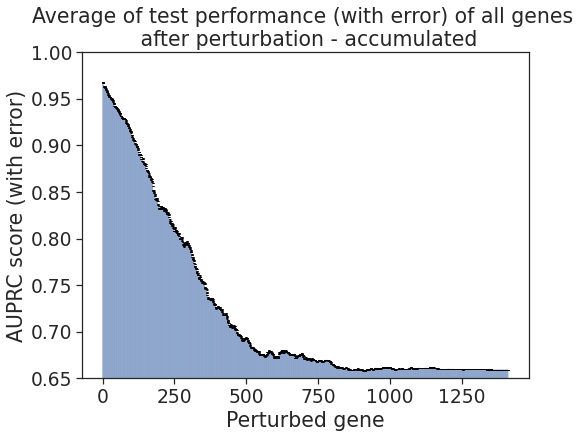

In [11]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated")
# plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

In [12]:
range(len(ranked_list))

range(0, 1413)

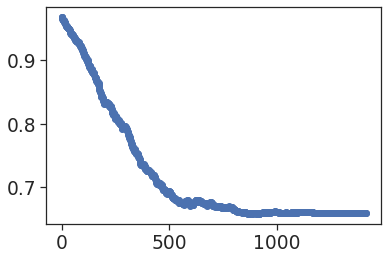

In [13]:
ftr_names = ranked_list
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

<Figure size 576x432 with 0 Axes>

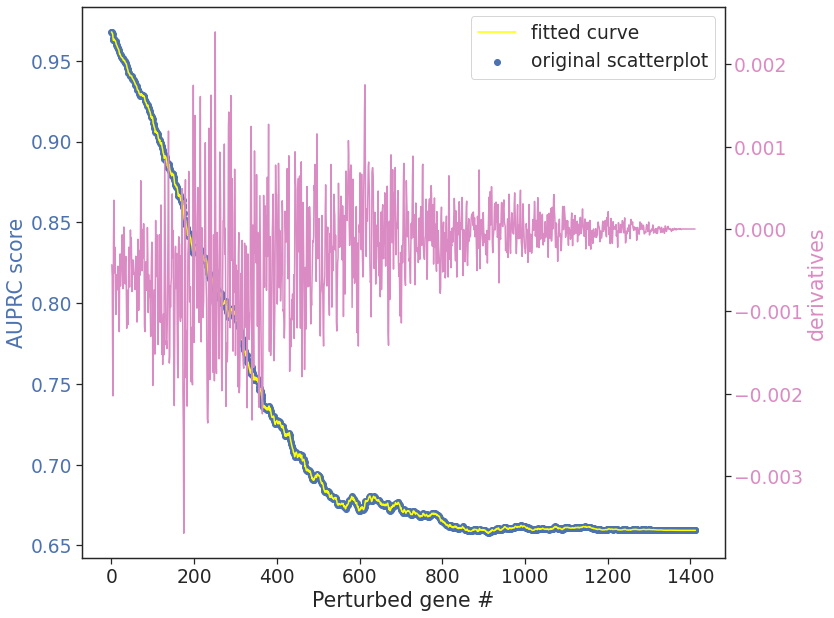

In [14]:
plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives.PDF', bbox_inches='tight')
plt.show()

In [15]:
ftr_names.reverse()

In [16]:
# acuumulated perturbation
np.random.seed(42)
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

for i in range(len(ftr_names)):
#     print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
#     print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

In [17]:
file = open('../results/results_bin_best/scores_accumulated_reversed.save', 'rb')
scores = pickle.load(file)
file.close()

In [18]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

In [26]:
file = open('../results/results_bin_best/scores_accumulated_reversed.save', 'rb')
scores = pickle.load(file)
file.close()

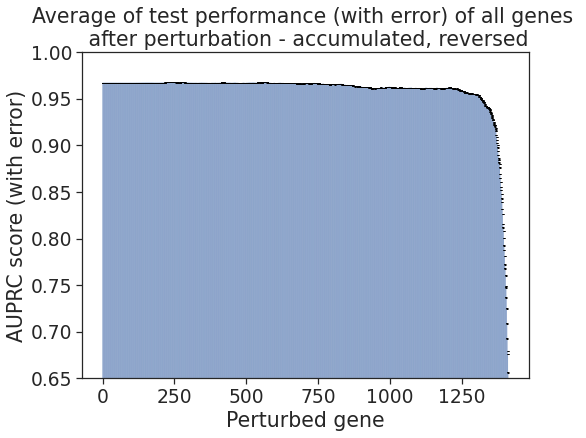

In [19]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed")
# plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked_reversed.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

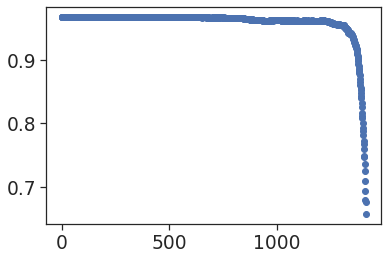

<Figure size 576x432 with 0 Axes>

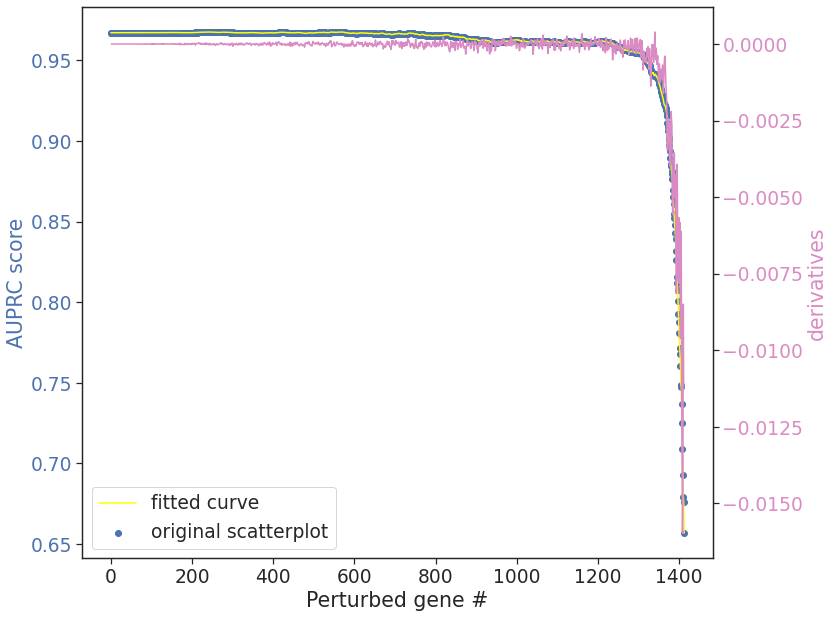

In [20]:
ftr_names = ranked_list
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives_reversed.PDF', bbox_inches='tight')
plt.show()

In [21]:
ranked_list.reverse()

In [22]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = X_test[ftr_names[i]]
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

In [41]:
scores

array([[0.96716483, 0.96716483, 0.96716483, ..., 0.96716483, 0.96716483,
        0.96716483],
       [0.96716483, 0.96716483, 0.96716483, ..., 0.96716483, 0.96716483,
        0.96716483],
       [0.96716483, 0.96716483, 0.96716483, ..., 0.96716483, 0.96716483,
        0.96716483],
       ...,
       [0.67919696, 0.67938282, 0.67960932, ..., 0.67848159, 0.67911772,
        0.67884881],
       [0.67566375, 0.67544728, 0.6758099 , ..., 0.67581995, 0.67596833,
        0.67601989],
       [0.65746647, 0.6561874 , 0.6559595 , ..., 0.65672505, 0.65684888,
        0.65529351]])

In [23]:
# file = open('../results/results_bin_best/scores_reconstituted.save', 'wb')
# pickle.dump(scores, file)
# file.close()

file = open('../results/results_bin_best/scores_reconstituted.save', 'rb')
scores = pickle.load(file)
file.close()

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

In [24]:
scores_df

0         1         2         3         4         5         6  \
0     0.676020  0.676020  0.676020  0.676020  0.676020  0.676020  0.676020   
1     0.678849  0.678849  0.678849  0.678849  0.678849  0.678849  0.678849   
2     0.692940  0.692940  0.692940  0.692940  0.692940  0.692940  0.692940   
3     0.709330  0.709330  0.709330  0.709330  0.709330  0.709330  0.709330   
4     0.724685  0.724685  0.724685  0.724685  0.724685  0.724685  0.724685   
...        ...       ...       ...       ...       ...       ...       ...   
1408  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165   
1409  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165   
1410  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165   
1411  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165   
1412  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165  0.967165   

             7         8         9      mean           std     gene  
0     0.676020  0.676020  0.676020  0.676020  1.164412e-16  Slc5a4b  
1     0.678849  0.678849  0.678849  0.678849  1.110223e-16  Slc13a4  
2     0.692940  0.692940  0.692940  0.692940  1.164412e-16  Hormad1  
3     0.709330  0.709330  0.709330  0.709330  0.000000e+00    Adam2  
4     0.724685  0.724685  0.724685  0.724685  1.110223e-16      C4b  
...        ...       ...       ...       ...           ...      ...  
1408  0.967165  0.967165  0.967165  0.967165  2.248030e-16    Ntng2  
1409  0.967165  0.967165  0.967165  0.967165  2.248030e-16    Sox10  
1410  0.967165  0.967165  0.967165  0.967165  2.248030e-16     Myl9  
1411  0.967165  0.967165  0.967165  0.967165  2.248030e-16    Abtb2  
1412  0.967165  0.967165  0.967165  0.967165  2.248030e-16     Dbx2  

[1413 rows x 13 columns]

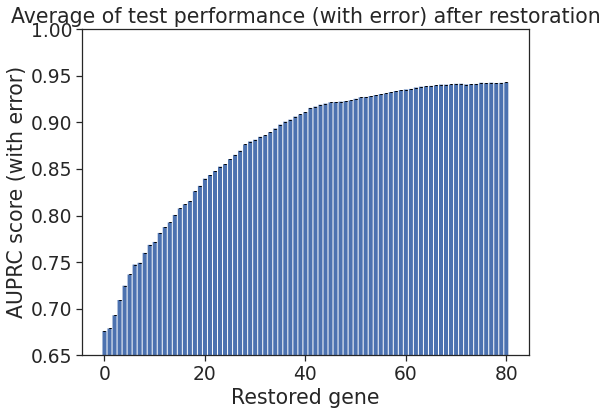

In [25]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(81), scores_df.loc[0:80,:]['mean'] , yerr=scores_df.loc[0:80,:]['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Restored gene')
plt.title("Average of test performance (with error) after restoration")
# plt.savefig('../figures/3_accumulated_restoration_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

In [142]:
from sklearn.inspection import permutation_importance

np.random.seed(42)
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])
X_test, y_test = final_data[0]
grid = final_models[0]
ftr_names = X_test.columns

# loop through the features

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),3),'+/-', np.around(np.std(auprc_scores),3))
    scores[i] = auprc_scores

shuffling Avp
shuffled test score: 0.967 +/- 0.0
shuffling Pmch
shuffled test score: 0.967 +/- 0.0
shuffling Oxt
shuffled test score: 0.967 +/- 0.0
shuffling Hcrt
shuffled test score: 0.967 +/- 0.0
shuffling Sst
shuffled test score: 0.967 +/- 0.0
shuffling Cartpt
shuffled test score: 0.967 +/- 0.0
shuffling Pomc
shuffled test score: 0.967 +/- 0.0
shuffling Trh
shuffled test score: 0.967 +/- 0.0
shuffling Tac2
shuffled test score: 0.967 +/- 0.0
shuffling Npy
shuffled test score: 0.967 +/- 0.0
shuffling Gal
shuffled test score: 0.967 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.967 +/- 0.0
shuffling Ptgds
shuffled test score: 0.967 +/- 0.0
shuffling Flt1
shuffled test score: 0.967 +/- 0.0
shuffling Vtn
shuffled test score: 0.967 +/- 0.0
shuffling Hba-a1
shuffled test score: 0.967 +/- 0.0
shuffling Slco1a4
shuffled test score: 0.967 +/- 0.0
shuffling Ebf1
shuffled test score: 0.967 +/- 0.0
shuffling C1qa
shuffled test score: 0.967 +/- 0.0
shuffling Ly6c1
shuffled test score: 0.967 +/- 

shuffled test score: 0.967 +/- 0.0
shuffling Slco1c1
shuffled test score: 0.967 +/- 0.0
shuffling A330008L17Rik
shuffled test score: 0.967 +/- 0.0
shuffling Zfp804a
shuffled test score: 0.967 +/- 0.0
shuffling Esr1
shuffled test score: 0.967 +/- 0.0
shuffling Cpa6
shuffled test score: 0.967 +/- 0.0
shuffling Fyb
shuffled test score: 0.967 +/- 0.0
shuffling Gm29773
shuffled test score: 0.967 +/- 0.0
shuffling Arhgap6
shuffled test score: 0.967 +/- 0.0
shuffling Itih3
shuffled test score: 0.967 +/- 0.0
shuffling Cntnap5b
shuffled test score: 0.967 +/- 0.0
shuffling Hs3st5
shuffled test score: 0.967 +/- 0.0
shuffling Cntn4
shuffled test score: 0.967 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.967 +/- 0.0
shuffling Slc16a10
shuffled test score: 0.967 +/- 0.0
shuffling Dach1
shuffled test score: 0.967 +/- 0.0
shuffling St18
shuffled test score: 0.967 +/- 0.0
shuffling Pbx3
shuffled test score: 0.967 +/- 0.0
shuffling Hs6st3
shuffled test score: 0.967 +/- 0.0
shuffling 9330185C12Rik
shuf

shuffled test score: 0.967 +/- 0.0
shuffling A2m
shuffled test score: 0.968 +/- 0.0
shuffling Pdzrn4
shuffled test score: 0.967 +/- 0.0
shuffling Zfp366
shuffled test score: 0.967 +/- 0.0
shuffling Igf1
shuffled test score: 0.967 +/- 0.0
shuffling Car4
shuffled test score: 0.967 +/- 0.0
shuffling Bmp6
shuffled test score: 0.967 +/- 0.0
shuffling 2010001K21Rik
shuffled test score: 0.967 +/- 0.0
shuffling Htr1f
shuffled test score: 0.967 +/- 0.0
shuffling Cdh8
shuffled test score: 0.967 +/- 0.0
shuffling Aldh1a1
shuffled test score: 0.967 +/- 0.0
shuffling Sec14l5
shuffled test score: 0.967 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.967 +/- 0.0
shuffling Nwd2
shuffled test score: 0.967 +/- 0.0
shuffling Myo5b
shuffled test score: 0.967 +/- 0.0
shuffling Myo1f
shuffled test score: 0.967 +/- 0.0
shuffling Mir670hg
shuffled test score: 0.967 +/- 0.0
shuffling Adgrf5
shuffled test score: 0.967 +/- 0.0
shuffling Fgf13
shuffled test score: 0.967 +/- 0.0
shuffling Gja1
shuffled test score

shuffled test score: 0.967 +/- 0.0
shuffling Ifitm3
shuffled test score: 0.967 +/- 0.0
shuffling Slc35f3
shuffled test score: 0.967 +/- 0.0
shuffling Gm45904
shuffled test score: 0.967 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.967 +/- 0.0
shuffling Itga1
shuffled test score: 0.967 +/- 0.0
shuffling Ndst3
shuffled test score: 0.967 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.967 +/- 0.0
shuffling Glra3
shuffled test score: 0.967 +/- 0.0
shuffling Foxq1
shuffled test score: 0.967 +/- 0.0
shuffling Opalin
shuffled test score: 0.967 +/- 0.0
shuffling Pde7b
shuffled test score: 0.967 +/- 0.0
shuffling Ak7
shuffled test score: 0.967 +/- 0.0
shuffling Kcnj8
shuffled test score: 0.967 +/- 0.0
shuffling Ptprm
shuffled test score: 0.967 +/- 0.0
shuffling Sema3e
shuffled test score: 0.967 +/- 0.0
shuffling 9530059O14Rik
shuffled test score: 0.967 +/- 0.0
shuffling Tshz2
shuffled test score: 0.967 +/- 0.0
shuffling Gm32828
shuffled test score: 0.968 +/- 0.0
shuffling Ptprc
shuffled test sc

shuffled test score: 0.967 +/- 0.0
shuffling Fgf10
shuffled test score: 0.967 +/- 0.0
shuffling Itgb5
shuffled test score: 0.967 +/- 0.0
shuffling Bcl11a
shuffled test score: 0.967 +/- 0.0
shuffling Bdnf
shuffled test score: 0.967 +/- 0.0
shuffling St6galnac5
shuffled test score: 0.967 +/- 0.0
shuffling Abcc4
shuffled test score: 0.967 +/- 0.0
shuffling Alcam
shuffled test score: 0.967 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.967 +/- 0.0
shuffling Cfap61
shuffled test score: 0.967 +/- 0.0
shuffling Anxa3
shuffled test score: 0.967 +/- 0.0
shuffling 1700016P03Rik
shuffled test score: 0.967 +/- 0.0
shuffling Ahnak
shuffled test score: 0.967 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.967 +/- 0.0
shuffling Utrn
shuffled test score: 0.967 +/- 0.0
shuffling Gm29683
shuffled test score: 0.967 +/- 0.0
shuffling Cdc14a
shuffled test score: 0.967 +/- 0.0
shuffling Nfia
shuffled test score: 0.967 +/- 0.0
shuffling Dab1
shuffled test score: 0.967 +/- 0.0
shuffling Csta2
shuffled test s

shuffled test score: 0.967 +/- 0.0
shuffling Slc16a2
shuffled test score: 0.967 +/- 0.0
shuffling Phldb2
shuffled test score: 0.967 +/- 0.0
shuffling Actn2
shuffled test score: 0.967 +/- 0.0
shuffling Sncaip
shuffled test score: 0.967 +/- 0.0
shuffling Crb1
shuffled test score: 0.967 +/- 0.0
shuffling Itga9
shuffled test score: 0.967 +/- 0.0
shuffling Aff2
shuffled test score: 0.967 +/- 0.0
shuffling Rbm47
shuffled test score: 0.967 +/- 0.0
shuffling Gm49906
shuffled test score: 0.967 +/- 0.0
shuffling Nxn
shuffled test score: 0.967 +/- 0.0
shuffling Oprm1
shuffled test score: 0.967 +/- 0.0
shuffling Plppr1
shuffled test score: 0.967 +/- 0.0
shuffling Gm41414
shuffled test score: 0.967 +/- 0.0
shuffling Nell2
shuffled test score: 0.967 +/- 0.0
shuffling 4930447C04Rik
shuffled test score: 0.967 +/- 0.0
shuffling Lncenc1
shuffled test score: 0.967 +/- 0.0
shuffling Gm2629
shuffled test score: 0.967 +/- 0.0
shuffling Airn
shuffled test score: 0.967 +/- 0.0
shuffling Socs2
shuffled test sc

shuffled test score: 0.967 +/- 0.0
shuffling Pecam1
shuffled test score: 0.967 +/- 0.0
shuffling Sema6a
shuffled test score: 0.967 +/- 0.0
shuffling Plscr4
shuffled test score: 0.967 +/- 0.0
shuffling Slc17a6
shuffled test score: 0.967 +/- 0.0
shuffling Shisa9
shuffled test score: 0.967 +/- 0.0
shuffling Maml2
shuffled test score: 0.967 +/- 0.0
shuffling St6galnac3
shuffled test score: 0.967 +/- 0.0
shuffling Kcnq3
shuffled test score: 0.967 +/- 0.0
shuffling Gabra2
shuffled test score: 0.967 +/- 0.0
shuffling Fmod
shuffled test score: 0.967 +/- 0.0
shuffling Gm12027
shuffled test score: 0.967 +/- 0.0
shuffling Samd5
shuffled test score: 0.967 +/- 0.0
shuffling Gm13561
shuffled test score: 0.967 +/- 0.0
shuffling Creb5
shuffled test score: 0.967 +/- 0.0
shuffling Cd247
shuffled test score: 0.967 +/- 0.0
shuffling Rasgrf2
shuffled test score: 0.967 +/- 0.0
shuffling Tmeff2
shuffled test score: 0.967 +/- 0.0
shuffling Sv2b
shuffled test score: 0.967 +/- 0.0
shuffling Pstpip2
shuffled tes

shuffled test score: 0.967 +/- 0.0
shuffling Irf8
shuffled test score: 0.967 +/- 0.0
shuffling Srgn
shuffled test score: 0.967 +/- 0.0
shuffling Kif26b
shuffled test score: 0.967 +/- 0.0
shuffling Patj
shuffled test score: 0.967 +/- 0.0
shuffling Efcab6
shuffled test score: 0.967 +/- 0.0
shuffling Bcl2
shuffled test score: 0.967 +/- 0.0
shuffling Gm9750
shuffled test score: 0.967 +/- 0.0
shuffling Hspb1
shuffled test score: 0.967 +/- 0.0
shuffling Npffr2
shuffled test score: 0.967 +/- 0.0
shuffling 1700028P14Rik
shuffled test score: 0.967 +/- 0.0
shuffling Thsd4
shuffled test score: 0.967 +/- 0.0
shuffling Gimap6
shuffled test score: 0.967 +/- 0.0
shuffling Gm21798
shuffled test score: 0.967 +/- 0.0
shuffling Prune2
shuffled test score: 0.967 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.967 +/- 0.0
shuffling March3
shuffled test score: 0.967 +/- 0.0
shuffling Egflam
shuffled test score: 0.967 +/- 0.0
shuffling Phactr2
shuffled test score: 0.967 +/- 0.0
shuffling Strip2
shuffled test

shuffled test score: 0.967 +/- 0.0
shuffling Wdr17
shuffled test score: 0.967 +/- 0.0
shuffling Rbm20
shuffled test score: 0.967 +/- 0.0
shuffling Dnah14
shuffled test score: 0.967 +/- 0.0
shuffling Fat1
shuffled test score: 0.967 +/- 0.0
shuffling Clybl
shuffled test score: 0.967 +/- 0.0
shuffling Kit
shuffled test score: 0.967 +/- 0.0
shuffling Rtn4rl1
shuffled test score: 0.967 +/- 0.0
shuffling Jam2
shuffled test score: 0.967 +/- 0.0
shuffling Zbbx
shuffled test score: 0.967 +/- 0.0
shuffling Slc24a4
shuffled test score: 0.967 +/- 0.0
shuffling Stk33
shuffled test score: 0.967 +/- 0.0
shuffling Gfra2
shuffled test score: 0.967 +/- 0.0
shuffling Gm32014
shuffled test score: 0.967 +/- 0.0
shuffling Ptger3
shuffled test score: 0.967 +/- 0.0
shuffling Zswim6
shuffled test score: 0.967 +/- 0.0
shuffling Gm32122
shuffled test score: 0.967 +/- 0.0
shuffling Gcnt2
shuffled test score: 0.967 +/- 0.0
shuffling Lpar1
shuffled test score: 0.967 +/- 0.0
shuffling 4930598N05Rik
shuffled test sco

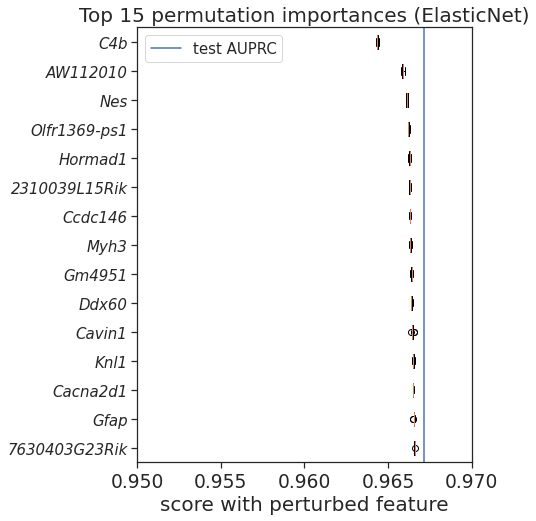

In [146]:
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
test_score = auc(recall, precision)

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

top15 = sorted_indcs[-15:]

plt.figure(figsize=(6, 8))
plt.boxplot(scores[top15].T, labels=np.array(ftr_names)[top15],vert=False)
# plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test AUPRC')
plt.title("Top 15 permutation importances (ElasticNet)", fontsize=20)
plt.xlabel('score with perturbed feature', fontsize=20)
plt.xlim(0.95, 0.97)
plt.yticks(fontsize=15)
plt.yticks(np.arange(1, 16), np.array(ftr_names)[top15], style='italic', fontsize=15)
plt.legend(fontsize=15)
#plt.savefig('../figures/3_eln_permutation_importance_top15.pdf', bbox_inches='tight')
plt.show()

## 3. Correlation matrix <a name="9.-corr"></a>

In [26]:
from src.data_processing import *
from src.grid_search import *

In [27]:
input_test = '../data/test_final_group_info.csv'
input_train = '../data/train_final_group_info.csv'

cell_type = 'All'

train_X, train_y, test_X, test_y, custom_cv = data_prep(input_test, input_train,
                                                        cell_type, binarization=True)

correlations = test_X.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

plt.figure(figsize=(12,5))

Finished data prepration for All


<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

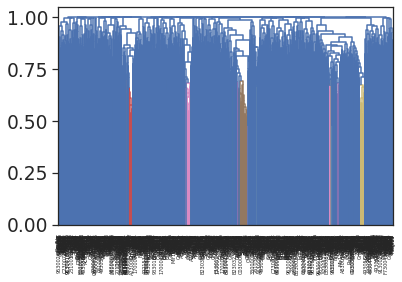

In [28]:
dendrogram(Z, labels=test_X.columns, orientation='top', 
           leaf_rotation=90);
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)
data = test_X
# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

correlations_2 = clustered.corr()

In [30]:
# correlations_2.to_csv('../results/correlation_matrix/binarized.csv')
correlations_2 = pd.read_csv('../results/correlation_matrix/binarized.csv', index_col=0)

In [31]:
train_X, train_y, test_X, test_y, custom_cv = data_prep(input_test, input_train,
                                                        cell_type, binarization=False)

correlations = test_X.corr()
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

plt.figure(figsize=(12,5))

dendrogram(Z, labels=test_X.columns, orientation='top', 
           leaf_rotation=90);
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

labels_order = np.argsort(labels)
data = test_X
# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

correlations = clustered.corr()

In [32]:
# correlations.to_csv('../results/correlation_matrix/nonbinarized.csv')
correlations = pd.read_csv('../results/correlation_matrix/nonbinarized.csv', index_col=0)

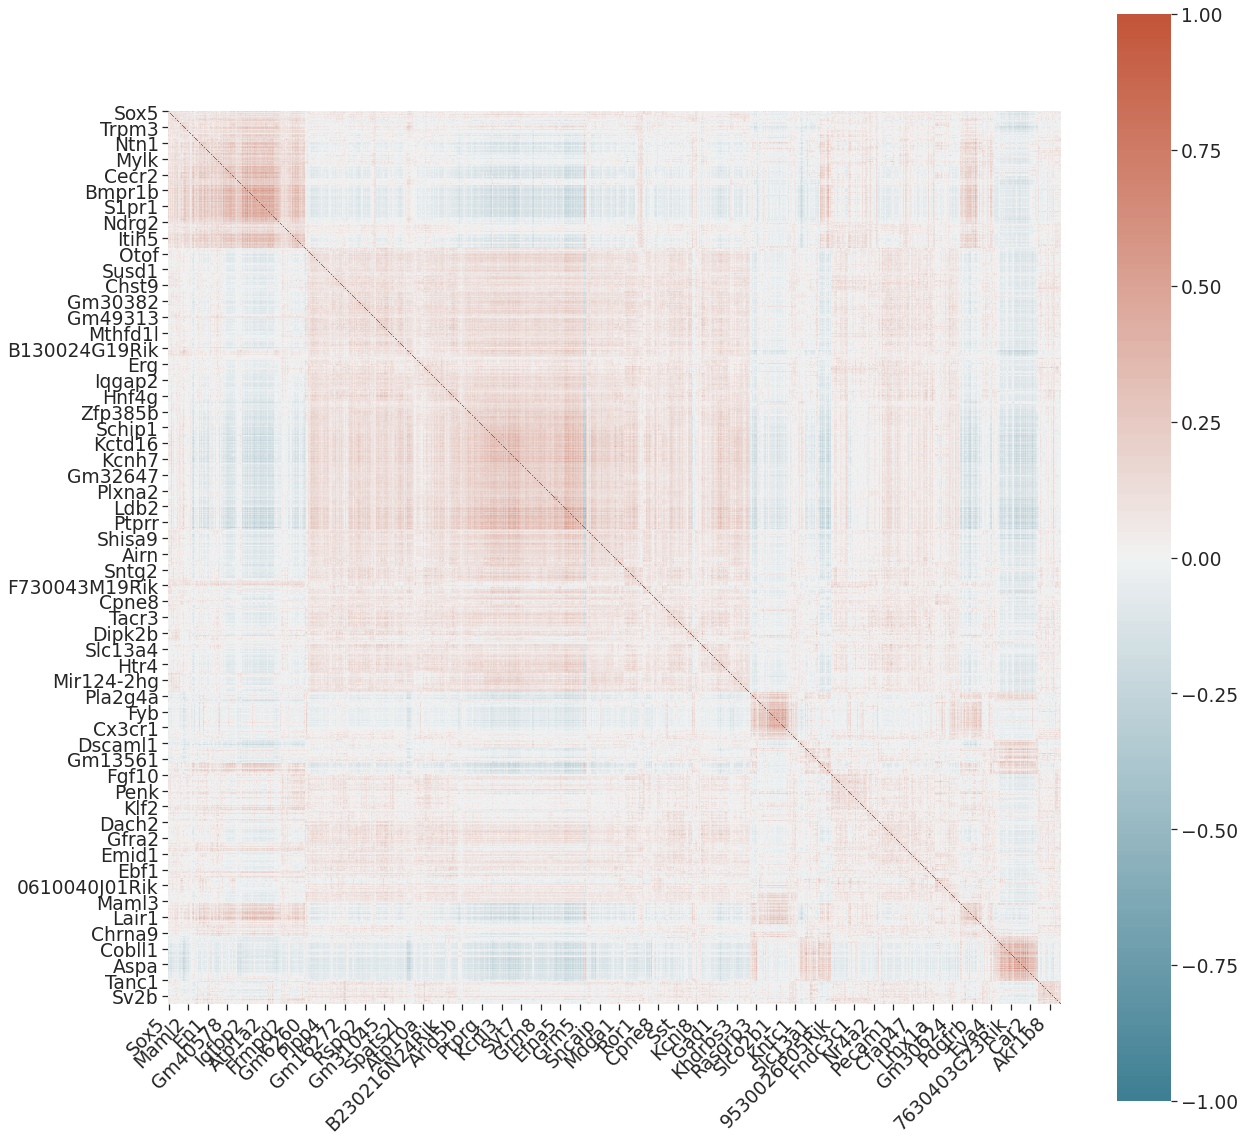

In [33]:
plt.figure(figsize=(20, 20))

ax = sns.heatmap(
    correlations_2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True 
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# plt.savefig('../figures/3_matrix_heatmap_bin.pdf', bbox_inches='tight')
plt.show()

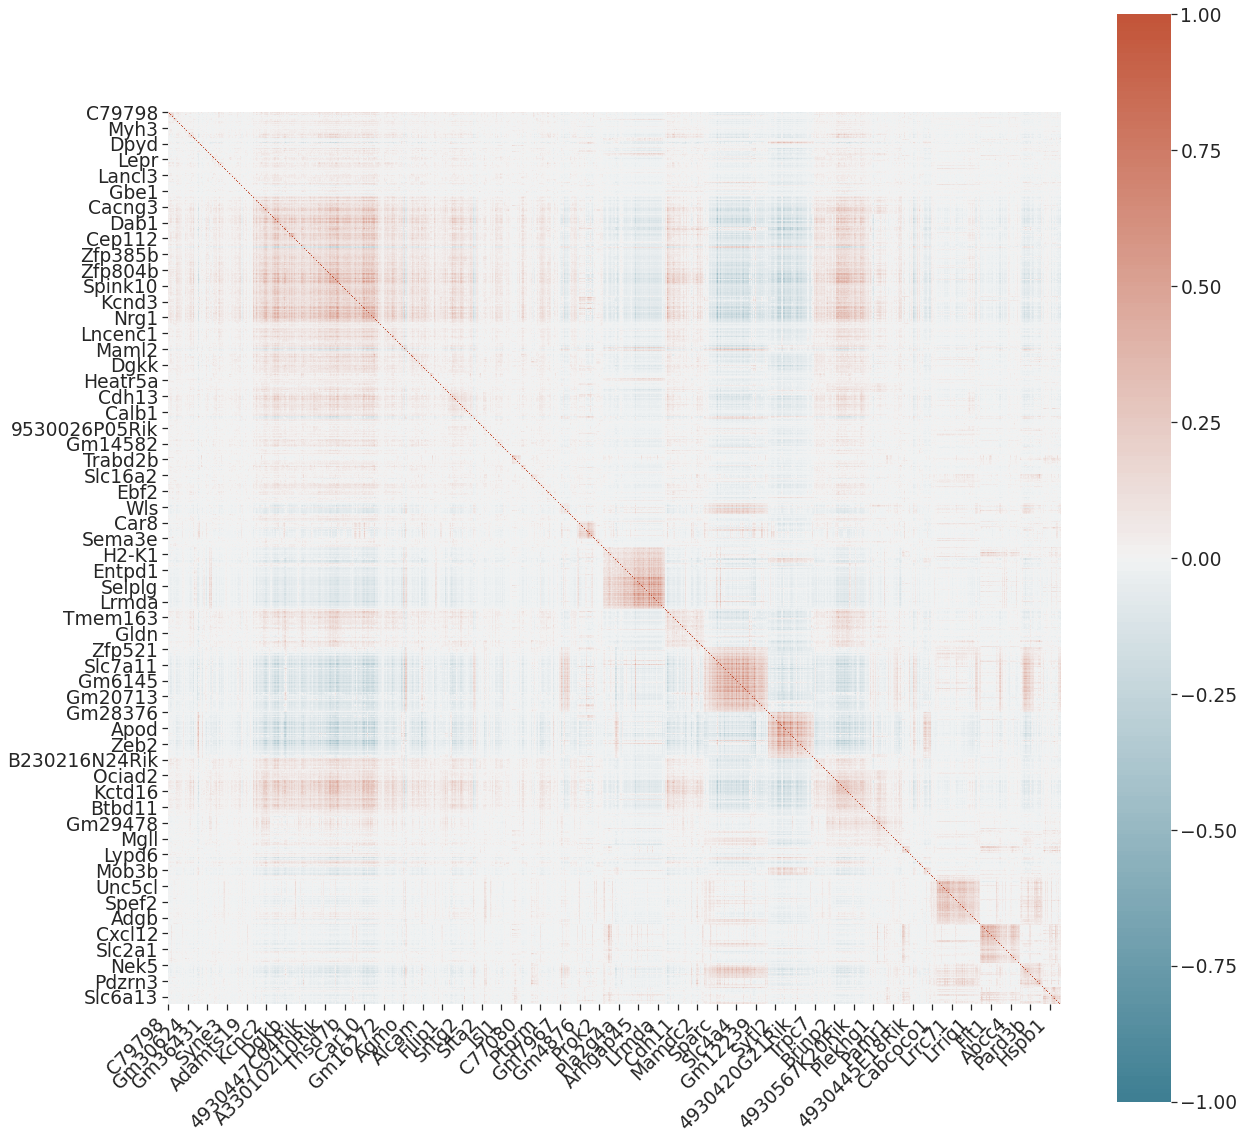

In [34]:
plt.figure(figsize=(20, 20))

ax = sns.heatmap(
    correlations, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True 
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# plt.savefig('../figures/3_matrix_heatmap_bin.pdf', bbox_inches='tight')
plt.show()

In [35]:
cluster1 = correlations_2.iloc[0:217, 0:217]
cluster2 = correlations_2.iloc[217:920, 217:920]
cluster3 = correlations_2.iloc[920:996, 920:996]
cluster4 = correlations_2.iloc[996:1009, 996:1009]
cluster5 = correlations_2.iloc[1009:1049, 1009:1049]
cluster6 = correlations_2.iloc[1049:1214, 1049:1214]
cluster7 = correlations_2.iloc[1214:1253, 1214:1253]
cluster8 = correlations_2.iloc[1253:1288, 1253:1288]
cluster9 = correlations_2.iloc[1288:1377, 1288:1377]
cluster10 = correlations_2.iloc[1377:-1, 1377:-1]

list(cluster1.columns)
cluster_list = ['cluster1',
 'cluster2',
 'cluster3',
 'cluster4',
 'cluster5',
 'cluster6',
 'cluster7',
 'cluster8',
 'cluster9',
 'cluster10']

In [36]:
top_coefs_result = [(result, X.columns[result[0]]) for result in results]
top_coefs_result.reverse()
# top_coefs_result = top_coefs_result + [(result, X.columns[result[0]]) for result in results][-nr_coefs:]# for result in results:
#     print(result, X.columns[result[0]])
top_coefs = [abs_coefs[t[0][0]] for t in top_coefs_result]
top_features = [t[1] for t in top_coefs_result]
std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

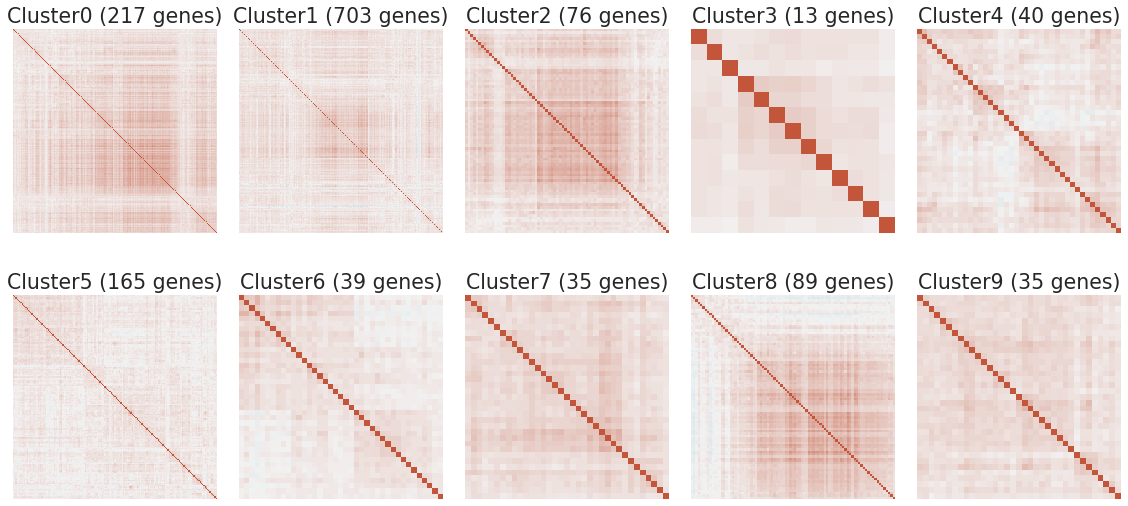

In [37]:
fig, axs  = plt.subplots(2,5, figsize=(16,8))

for i in list(cluster_list):
    number = cluster_list.index(i)
    row_number = int(number/5) 
    col_number = number%5
    cluster = locals()[i]
    sns.heatmap(
        cluster, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True, ax=axs[row_number, col_number],
        cbar=False,
        xticklabels=False,
        yticklabels=False)
    axs[row_number, col_number].set_title(f'Cluster{number} ({cluster.shape[0]} genes)')

plt.tight_layout()
# plt.savefig('../figures/S3e_individual_matrix.pdf')
plt.show()

In [41]:
cluster_list = [cluster1, cluster2, cluster3, cluster4, cluster5,
                cluster6, cluster7, cluster8, cluster9, cluster10]

In [42]:
nr_runs = 10
scores = np.zeros([len(cluster_list),nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

for i in range(len(cluster_list)):
    cluster = cluster_list[i]
    print('shuffling cluster'+ str(i), 'size=', cluster.shape[0])
    
    auprc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        gene_list = list(cluster.columns)
        for genes in gene_list:
            X_test_shuffled[genes] = np.random.permutation(X_test[genes].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling cluster0 size= 217
shuffled test score: 0.9568 +/- 0.0001
shuffling cluster1 size= 703
shuffled test score: 0.9588 +/- 0.0005
shuffling cluster2 size= 76
shuffled test score: 0.9655 +/- 0.0001
shuffling cluster3 size= 13
shuffled test score: 0.9662 +/- 0.0
shuffling cluster4 size= 40
shuffled test score: 0.9597 +/- 0.0001
shuffling cluster5 size= 165
shuffled test score: 0.9588 +/- 0.0003
shuffling cluster6 size= 39
shuffled test score: 0.9671 +/- 0.0001
shuffling cluster7 size= 35
shuffled test score: 0.9654 +/- 0.0001
shuffling cluster8 size= 89
shuffled test score: 0.9605 +/- 0.0001
shuffling cluster9 size= 35
shuffled test score: 0.9617 +/- 0.0001


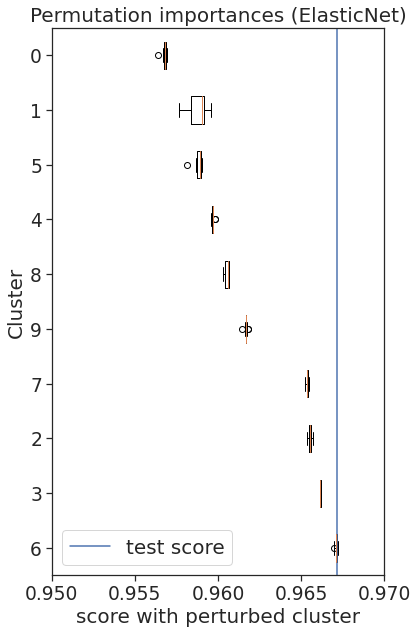

In [43]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

y_test_prob = grid.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
test_score = auc(recall, precision)

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6, 9))
plt.boxplot(scores[sorted_indcs].T, labels=sorted_indcs, vert=False)
# plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test score')
plt.title("Permutation importances (ElasticNet)", fontsize=20)
plt.xlim(0.95, 0.97)
plt.xlabel('score with perturbed cluster', fontsize=20)
plt.ylabel('Cluster', fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
# plt.savefig('../figures/3_cluster_perturbation.pdf')
plt.show()